In [146]:
import torchvision
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
from datasets import load_dataset
from torchvision import transforms
import numpy as np

In [147]:
def show_images(x):
    x = x*0.5+0.5
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1,2,0).clip(0,1)*255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8)).show()
    return grid_im
def make_grid(images,size=64):
    output_im = Image.new('RGB',(size * len(images), size))
    for i,im in enumerate(images):
        output_im.paste(im.resize((size,size)),(i*size,0))
    return output_im

In [148]:
dataset = load_dataset('imagefolder',data_dir='./data/ss/',split='train')
dataset

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

Dataset({
    features: ['image'],
    num_rows: 40
})

In [149]:
dataset[10]['image'].convert('RGB').size

(270, 275)

In [150]:
image_size = 128
batch_size = 8

In [151]:
preprocess = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor()
])
def transform(examples):
    images = [preprocess(image.convert('RGB')) for image in examples['image']]
    return {"images":images}
dataset.set_transform(transform)


train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True)
dataset[39]['images']

tensor([[[0.7529, 0.7529, 0.7451,  ..., 0.2510, 0.2941, 0.3176],
         [0.7765, 0.7569, 0.7373,  ..., 0.3020, 0.3137, 0.3176],
         [0.7804, 0.7608, 0.7569,  ..., 0.3137, 0.3137, 0.3098],
         ...,
         [0.7490, 0.7412, 0.7176,  ..., 0.5529, 0.6000, 0.6471],
         [0.7569, 0.7529, 0.7333,  ..., 0.5569, 0.6118, 0.6627],
         [0.7569, 0.7569, 0.7451,  ..., 0.5294, 0.5882, 0.6824]],

        [[0.6824, 0.6941, 0.6902,  ..., 0.2549, 0.2941, 0.3176],
         [0.7098, 0.6980, 0.6784,  ..., 0.3098, 0.3216, 0.3255],
         [0.7098, 0.6980, 0.6980,  ..., 0.3216, 0.3216, 0.3176],
         ...,
         [0.7255, 0.7176, 0.6941,  ..., 0.5686, 0.6196, 0.6627],
         [0.7294, 0.7255, 0.7098,  ..., 0.5843, 0.6353, 0.6863],
         [0.7373, 0.7333, 0.7176,  ..., 0.5647, 0.6196, 0.7137]],

        [[0.5882, 0.5961, 0.5922,  ..., 0.2549, 0.2902, 0.3137],
         [0.6118, 0.5961, 0.5804,  ..., 0.3059, 0.3176, 0.3216],
         [0.6157, 0.6000, 0.6039,  ..., 0.3176, 0.3176, 0.

In [152]:
len(train_dataloader)

5

In [153]:
train_dataloader

In [154]:
next(iter(train_dataloader))['images'].shape

torch.Size([8, 3, 128, 128])

In [155]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
xb = next(iter(train_dataloader))['images'].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb)


X shape: torch.Size([8, 3, 128, 128])


In [156]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000,beta_start=0.001,beta_end=0.004)

In [158]:
timesteps = torch.linspace(0,999,8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb,noise,timesteps)
print(timesteps)
print(noisy_xb.shape)
show_images(noisy_xb)

tensor([  0, 142, 285, 428, 570, 713, 856, 999])
torch.Size([8, 3, 128, 128])


In [159]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

In [160]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 128, 128])

In [162]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000,beta_start=0.001,beta_end=0.004)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

Epoch:5, loss: 0.04890056550502777
Epoch:10, loss: 0.045918183773756026
Epoch:15, loss: 0.03309494890272617
Epoch:20, loss: 0.028916480764746667
Epoch:25, loss: 0.024853066354990006
Epoch:30, loss: 0.022767762839794158


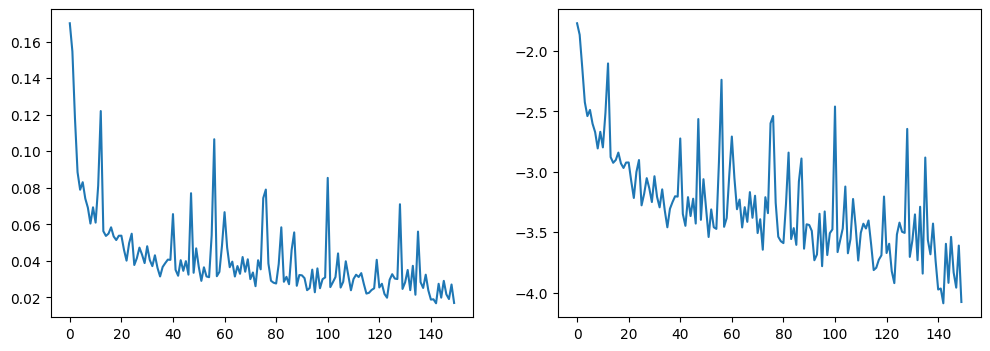

In [163]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

In [164]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

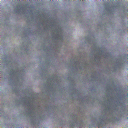

In [165]:
pipeline_output = image_pipe()
pipeline_output.images[0]